Dal raster in formato TIFF recupero le coordinate geografiche che uso per estrarre i dati di NDVI dai file netCDF

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np

In [3]:
import os
import glob

raster_folder = "./rasters/"
rasters = glob.glob(raster_folder+'*.tif')
rasters

['./rasters\\adda.tif',
 './rasters\\dora.tif',
 './rasters\\emiliani1.tif',
 './rasters\\emiliani2.tif',
 './rasters\\garda.tif',
 './rasters\\lambro.tif',
 './rasters\\oglio.tif',
 './rasters\\piemonte_nord.tif',
 './rasters\\piemonte_sud.tif',
 './rasters\\ticino.tif']

In [4]:
files = glob.glob('*.nc')
files

['adda.nc',
 'dora.nc',
 'emiliani1.nc',
 'emiliani2.nc',
 'garda.nc',
 'lambro.nc',
 'oglio.nc',
 'piemonte_nord.nc',
 'piemonte_sud.nc',
 'ticino.nc']

In [46]:
ndvi = xr.open_dataset('adda.nc').load()
ndvi = ndvi.assign_coords(lat=ndvi.lat.round(4), lon=ndvi.lon.round(4))
datetimeindex = ndvi.indexes['time'].to_datetimeindex()
# il formato della data di default di xarray non è compatibile direttamente con pandas, per cui sfrutto xarray per calcolarmi rapidamente
# la versione in formato DateTimeindex che rimpiazzerò nel dataframe pandas
ndvi['time'] = datetimeindex
ndvi

<xarray.Dataset>
Dimensions:                   (time: 463, lat: 701, lon: 812)
Coordinates:
  * time                      (time) datetime64[ns] 2000-02-18 ... 2021-02-18
  * lat                       (lat) float64 46.57 46.57 46.57 ... 45.12 45.11
  * lon                       (lon) float64 8.937 8.938 8.941 ... 10.62 10.63
Data variables:
    crs                       int8 -127
    _250m_16_days_NDVI        (time, lat, lon) float32 nan nan nan ... nan nan
    _250m_16_days_VI_Quality  (time, lat, lon) float64 nan nan nan ... nan nan
Attributes:
    title:        MOD13Q1.061 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v2.70
    references:   See README.md
    history:      See README.md

non riesco a trovare una corrispondenza 1:1 tra il file netCDF e le coordinate del raster estratto usando QGIS, per cui mi accontento di una approssimazione

In [47]:
cultivable = xr.open_rasterio('./rasters/adda.tif')
cultivable = cultivable.assign_coords(x=cultivable.x.round(4), y=cultivable.y.round(4)) 

In [48]:
#mask_lon = np.isclose(ndvi.lon, cultivable.x)
#mask_lat = np.isclose(ndvi.lat, cultivable.y[1:])
#mask_lon = xr.DataArray(mask_lon, dims='lon')
#mask_lat = xr.DataArray(mask_lat, dims='lat')

mask_lon = ndvi.lon.isin(cultivable.x)
mask_lat = ndvi.lat.isin(cultivable.y[1:])

usando xarray, taglio il dataset originale in modo che le colonne di lat e long contegano solamente valori compresi in quelli arrotondati

In [49]:
cropped_ndvi = ndvi.where(mask_lon & mask_lat, drop=True)
cropped_ndvi

<xarray.Dataset>
Dimensions:                   (lon: 676, lat: 234, time: 463)
Coordinates:
  * time                      (time) datetime64[ns] 2000-02-18 ... 2021-02-18
  * lat                       (lat) float64 46.57 46.56 46.55 ... 45.12 45.11
  * lon                       (lon) float64 8.938 8.941 8.943 ... 10.62 10.63
Data variables:
    crs                       (lon, lat) float64 -127.0 -127.0 ... -127.0 -127.0
    _250m_16_days_NDVI        (time, lat, lon) float32 nan nan nan ... nan nan
    _250m_16_days_VI_Quality  (time, lat, lon) float64 nan nan nan ... nan nan
Attributes:
    title:        MOD13Q1.061 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v2.70
    references:   See README.md
    history:      See README.md

estraggo l'ndvi solamente per quelle coppie di punti di lat e long che identificano la regione di studio

In [50]:
raster = cultivable.to_dataset('band').to_dataframe().reset_index().rename(columns={1:'band'})
raster = raster.loc[raster.band == 1].reset_index(drop=True)
raster['comb'] = raster.apply(lambda x: (x.x, x.y), axis=1)

In [51]:
df = cropped_ndvi.to_dataframe().reset_index()
df = df[['time','lon','lat','_250m_16_days_NDVI']]
df = df.loc[~df._250m_16_days_NDVI.isna()].reset_index(drop=True)
df['comb'] = df.apply(lambda x: (x['lon'], x['lat']), axis=1)
frame = df.loc[df.comb.isin(raster.comb)]
frame.head()

MemoryError: Unable to allocate 1.09 GiB for an array with shape (2, 73239192) and data type float64

questo è un esempio di plot per una determinata data di quanto estratto

In [38]:
plot = frame.loc[frame.time=='2000-02-18']

In [42]:
plot = plot.iloc[:, 1:4]

<AxesSubplot:>

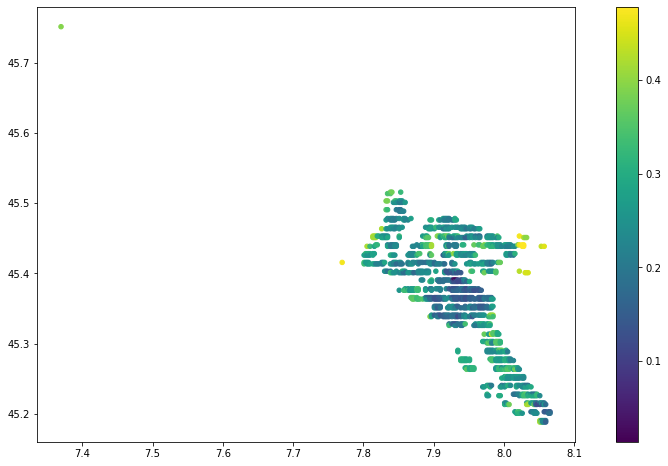

In [45]:
from shapely.geometry import Point
import matplotlib.pyplot as plt

fig,ax=plt.subplots(figsize=(15,8))
gdf = gpd.GeoDataFrame(plot, geometry=[Point(xy) for xy in zip(plot.lon,plot.lat)])
gdf.plot(ax=ax,markersize=20,marker='o',label='SMN',column='_250m_16_days_NDVI',legend=True)

plot del raster originale per avere un confronto

<AxesSubplot:>

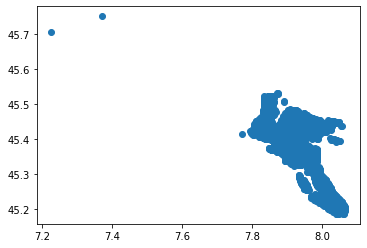

In [13]:
gdf = gpd.GeoDataFrame(raster, geometry=[Point(xy) for xy in zip(raster.x,raster.y)])
gdf.plot()

In [14]:
raster

,y,x,band,comb,geometry
0,45.7510,7.3698,1.0,"(7.3698, 45.751)",POINT (7.36980 45.75100)
1,45.7072,7.2260,1.0,"(7.226, 45.7072)",POINT (7.22600 45.70720)
2,45.5322,7.8719,1.0,"(7.8719, 45.5322)",POINT (7.87190 45.53220)
3,45.5322,7.8739,1.0,"(7.8739, 45.5322)",POINT (7.87390 45.53220)
4,45.5301,7.8739,1.0,"(7.8739, 45.5301)",POINT (7.87390 45.53010)
...,...,...,...,...,...
4006,45.1864,8.0406,1.0,"(8.0406, 45.1864)",POINT (8.04060 45.18640)
4007,45.1864,8.0427,1.0,"(8.0427, 45.1864)",POINT (8.04270 45.18640)
4008,45.1864,8.0469,1.0,"(8.0469, 45.1864)",POINT (8.04690 45.18640)
4009,45.1864,8.0594,1.0,"(8.0594, 45.1864)",POINT (8.05940 45.18640)


In [15]:
df = frame.groupby('time', as_index=False).apply(lambda x: x['_250m_16_days_NDVI'].mean())
df['time'] = datetimeindex
df.head()

,time,None
0,2000-02-18,0.248352
1,2000-03-05,0.247521
2,2000-03-21,0.324672
3,2000-04-06,0.417709
4,2000-04-22,0.443699


In [18]:
df

,time,None
0,2000-02-18,0.248352
1,2000-03-05,0.247521
2,2000-03-21,0.324672
3,2000-04-06,0.417709
4,2000-04-22,0.443699
...,...,...
458,2020-12-18,0.401312
459,2021-01-01,0.412257
460,2021-01-17,0.386926
461,2021-02-02,0.396763


In [17]:
rasters

['./rasters\\adda.tif',
 './rasters\\dora.tif',
 './rasters\\emiliani1.tif',
 './rasters\\emiliani2.tif',
 './rasters\\garda.tif',
 './rasters\\lambro.tif',
 './rasters\\oglio.tif',
 './rasters\\piemonte_nord.tif',
 './rasters\\piemonte_sud.tif',
 './rasters\\ticino.tif']

In [16]:
raster_tuples = [[] for i in range(len(rasters))]

for i in range(len(rasters)):
    raster = xr.open_rasterio(rasters[i]).to_dataset('band').to_dataframe().reset_index().rename(columns={1:'band'}) # apro il ritaglio e lo converto in dataframe
    raster = raster.loc[raster.band == 1].reset_index(drop=True) 
    raster_tuples[i].append([tuple(x) for x in np.around(raster[['x','y']].to_numpy(), decimals=3)])

    subset = raster[['x','y']]
    #subset = subset.round(2)
    raster_tuples[i].append([tuple(x) for x in subset.to_numpy()])

In [ ]:
for i in range(len(files)):
    ndvi = xr.open_dataset(files[i]).load()
    ndvi = ndvi.assign_coords(lat=ndvi.lat.round(3), lon=ndvi.lon.round(3))
    datetimeindex = ndvi.indexes['time'].to_datetimeindex()
    mask_lon = ndvi.lon.isin(np.around(raster.x.values, decimals=5))
    mask_lat = ndvi.lat.isin(np.around(raster.y.values, decimals=5))
    cropped_ndvi =  ndvi.where(mask_lon & mask_lat, drop=True)
    df = cropped_ndvi.to_dataframe().reset_index()
    df = df[['time','lon','lat','_250m_16_days_NDVI']]
    df = df.loc[~df._250m_16_days_NDVI.isna()].reset_index(drop=True)
    df['comb'] = df.apply(lambda x: (x['lon'], x['lat']), axis=1)
    frame = df.loc[df.comb.isin(raster_tuples[i])]